# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [20]:
# Import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# For token part
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# For sklearn
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Load data from the SQLite database
engine = create_engine('sqlite:///DisasterResponse.db')  # DB file name from ETL
df = pd.read_sql_table('DisasterResponse', engine)

# Define feature (X) and target (Y) variables
X = df['message']
# Y = df.iloc[:, 4:]
Y = df.drop(['id', 'message', 'original', 'genre'], axis=1)

# Display the first few rows of the data to verify it's loaded correctly
print(df.head())

   id                                            message  \
0   2  Weather update - a cold front from Cuba that c...   
1   7            Is the Hurricane over or is it not over   
2   8                    Looking for someone but no name   
3   9  UN reports Leogane 80-90 destroyed. Only Hospi...   
4  12  says: west side of Haiti, rest of the country ...   

                                            original   genre  related  \
0  Un front froid se retrouve sur Cuba ce matin. ...  direct        1   
1                 Cyclone nan fini osinon li pa fini  direct        1   
2  Patnm, di Maryani relem pou li banm nouvel li ...  direct        1   
3  UN reports Leogane 80-90 destroyed. Only Hospi...  direct        1   
4  facade ouest d Haiti et le reste du pays aujou...  direct        1   

   request  offer  aid_related  medical_help  medical_products      ...        \
0        0      0            0             0                 0      ...         
1        0      0            1        

### 2. Write a tokenization function to process your text data

In [3]:
# Define the tokenization function
def tokenize(text):
    # Normalize text by converting to lowercase and removing special characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # Tokenize words
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [word for word in tokens if word not in stopwords.words("english")]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return clean_tokens

In [4]:
# Example usage:
example_text = "Weather update - a magic food from Viet Nam that caused heavy cloudy and meetball!"
print(tokenize(example_text))

['weather', 'update', 'magic', 'food', 'viet', 'nam', 'caused', 'heavy', 'cloudy', 'meetball']


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
# Define the machine learning pipeline

# Step 1: TF-IDF Vectorizer to convert text data into numeric feature vectors
# - tokenizer=tokenize: Use the custom tokenization function we defined to process text
# - use_idf=True: Enable inverse document frequency (IDF) to reduce the impact of frequently occurring words
# - smooth_idf=True: Prevent division by zero for unseen terms by adding 1 to document frequencies
# - sublinear_tf=False: Do not scale term frequency logarithmically
vectorizer = TfidfVectorizer(tokenizer=tokenize, use_idf=True, smooth_idf=True, sublinear_tf=False)

# Step 2: RandomForestClassifier wrapped inside MultiOutputClassifier
# - RandomForestClassifier(random_state=42): Base classifier with random state for reproducibility
# - MultiOutputClassifier: Allows RandomForest to handle multiple output labels (for multi-label classification)
clf = MultiOutputClassifier(RandomForestClassifier(random_state=42))

# Step 3: Create the pipeline
# - The pipeline chains two steps: 
#     1. Convert raw text into TF-IDF feature vectors using 'vectorizer'
#     2. Apply the classifier 'clf' to predict the multiple output categories
pipeline = Pipeline([
    ('vectorizer', vectorizer),  # Step to convert text data to numerical format
    ('clf', clf)                 # Step to train the multi-label classifier
])

# The pipeline will take in raw text as input, process it through the TF-IDF vectorizer, 
# and then use the multi-output classifier to predict multiple categories.

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
# Step 1: Split the data into training and test sets
# - X is the feature (input message)
# - Y is the target (categories)
# - test_size=0.2: 20% of the data will be used as the test set
# - random_state=42: Ensures reproducibility of the split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step 2: Train the pipeline
# - Fit the pipeline to the training data (X_train, Y_train)
print("Training the pipeline...")
pipeline.fit(X_train, Y_train)

# Pipeline is now trained and ready for testing or further evaluation
print("Pipeline training completed.")

Training the pipeline...
Pipeline training completed.


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [7]:
def get_metrics(test_value, predicted_value):
    # Calculate accuracy
    accuracy = accuracy_score(test_value, predicted_value)

    # Try calculating precision and handle any division by zero manually
    try:
        precision = round(precision_score(test_value, predicted_value, average='weighted'))
    except ZeroDivisionError:
        precision = 0.0

    # Calculate recall
    recall = recall_score(test_value, predicted_value, average='weighted')
    
    # Try calculating F1 score and handle division by zero manually
    try:
        f1 = f1_score(test_value, predicted_value, average='weighted')
    except ZeroDivisionError:
        f1 = 0.0
    
    # Return all metrics as a dictionary
    return {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'Recall': recall}

# Use the trained pipeline to make predictions on the training data
y_pred_train = pipeline.predict(X_train)

# Use the trained pipeline to make predictions on the testing data
y_pred_test = pipeline.predict(X_test)

In [8]:
# Initialize an empty list to store the training results for each category
train_results = []

# Loop through each category (label) in the training data
# 'Y_train.columns' contains the names of the categories (e.g., 'related', 'request', etc.)
for i, column in enumerate(Y_train.columns):
    # Get the actual and predicted values for the current category (column)
    # 'iloc[:, i]' selects all rows and the ith column (label) for the actual values
    # 'y_pred_train[:, i]' selects all rows and the ith column (label) for the predicted values
    result = get_metrics(Y_train.iloc[:, i].values, y_pred_train[:, i])
    
    # Append the computed metrics (accuracy, precision, recall, F1) to the train_results list
    train_results.append(result)
    
# Temp print for dev (remove later)
train_results_df = pd.DataFrame(train_results)
print(train_results_df)

# Convert the list of dictionaries (metrics for each category) into a DataFrame for better visualization
train_results_df = pd.DataFrame(train_results)

    Accuracy  F1 Score  Precision    Recall
0   0.989224  0.989189        1.0  0.989224
1   0.987030  0.986839        1.0  0.987030
2   0.999094  0.999042        1.0  0.999094
3   0.985600  0.985575        1.0  0.985600
4   0.988318  0.987901        1.0  0.988318
5   0.992323  0.992026        1.0  0.992323
6   0.994135  0.993807        1.0  0.994135
7   0.994612  0.994163        1.0  0.994612
8   0.995852  0.995723        1.0  0.995852
9   1.000000  1.000000        1.0  1.000000
10  0.995375  0.995293        1.0  0.995375
11  0.995470  0.995433        1.0  0.995470
12  0.993467  0.993355        1.0  0.993467
13  0.998236  0.998184        1.0  0.998236
14  0.995518  0.995290        1.0  0.995518
15  0.996853  0.996602        1.0  0.996853
16  0.994564  0.994332        1.0  0.994564
17  0.993420  0.993175        1.0  0.993420
18  0.977685  0.976814        1.0  0.977685
19  0.985981  0.985202        1.0  0.985981
20  0.989987  0.989405        1.0  0.989987
21  0.991846  0.991517        1.

In [9]:
# Convert the list of dictionaries (metrics for each category) into a DataFrame for better visualization
train_results_df = pd.DataFrame(train_results)

# Initialize an empty list to store the test results for each category
test_results = []

# Loop through each category (label) in the testing data (similar to the training loop above)
for i, column in enumerate(Y_test.columns):
    # Get the actual and predicted values for the current category (column)
    result = get_metrics(Y_test.iloc[:, i].values, y_pred_test[:, i])
    
    # Append the computed metrics for the test data to the test_results list
    test_results.append(result)

# Temp print for dev (remove later)
test_results_df = pd.DataFrame(test_results)
print(test_results_df)
    
# Convert the test results into a DataFrame
test_results_df = pd.DataFrame(test_results)

    Accuracy  F1 Score  Precision    Recall
0   0.801869  0.792810        1.0  0.801869
1   0.888063  0.874737        1.0  0.888063
2   0.995042  0.992569        1.0  0.995042
3   0.750763  0.745992        1.0  0.750763
4   0.921625  0.895885        1.0  0.921625
5   0.952136  0.934788        1.0  0.952136
6   0.976735  0.966775        1.0  0.976735
7   0.982838  0.975072        1.0  0.982838
8   0.971968  0.961617        1.0  0.971968
9   1.000000  1.000000        1.0  1.000000
10  0.951754  0.941651        1.0  0.951754
11  0.936690  0.930315        1.0  0.936690
12  0.931350  0.917624        1.0  0.931350
13  0.987414  0.982807        1.0  0.987414
14  0.981312  0.973389        1.0  0.981312
15  0.988558  0.983238        1.0  0.988558
16  0.967582  0.954233        1.0  0.967582
17  0.959191  0.945442        1.0  0.959191
18  0.867849  0.815964        1.0  0.867849
19  0.936690  0.907540        1.0  0.936690
20  0.955187  0.936866        1.0  0.955187
21  0.952708  0.935352        1.

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


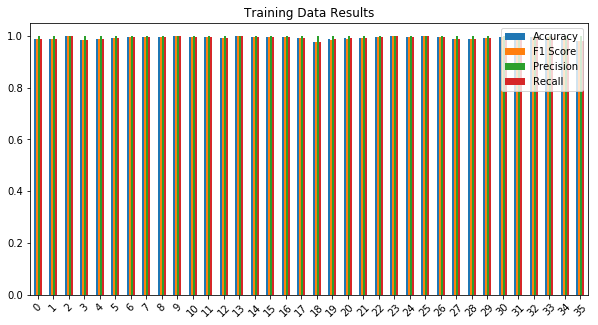

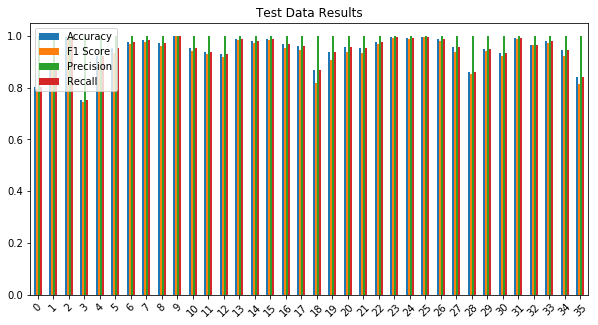

Average Training Results:
 Accuracy     0.992956
F1 Score     0.992713
Precision    1.000000
Recall       0.992956
dtype: float64
Average Test Results:
 Accuracy     0.945175
F1 Score     0.933266
Precision    1.000000
Recall       0.945175
dtype: float64


In [10]:
# Plot the training results for each metric (Accuracy, Precision, Recall, F1 Score) as a bar chart
train_results_df.plot(kind='bar', figsize=(10, 5), title="Training Data Results", rot=45)
plt.show()  # Display the plot

# Plot the test results for each metric as a bar chart
test_results_df.plot(kind='bar', figsize=(10, 5), title="Test Data Results", rot=45)
plt.show()  # Display the plot

# Print the average (mean) metrics across all categories for the training data
# This helps to get a summary view of how well the model is performing overall
print("Average Training Results:\n", train_results_df.mean())

# Print the average (mean) metrics across all categories for the testing data
# This helps to assess the overall model performance on unseen data
print("Average Test Results:\n", test_results_df.mean())

### 6. Improve your model
Use grid search to find better parameters. 

In [11]:
# Define a custom scorer function for multi-output classification
def multi_class_score(y_true, y_pred):
    accuracy_results = []
    
    # Loop through each target label (column)
    for i,column in enumerate(Y_train.columns):
        # Calculate accuracy for the current label (i-th column)
        accuracy = accuracy_score(y_true.loc[:,column].values,y_pred[:,i])
        accuracy_results.append(accuracy)  # Store the accuracy in a list
    
    # Calculate the mean accuracy across all labels
    avg_accuracy = np.mean(accuracy_results)
    return avg_accuracy  # Return the average accuracy

# Wrap the custom scoring function with 'make_scorer' so it can be used in GridSearchCV
score = make_scorer(multi_class_score)

# Define a parameter grid for the RandomForestClassifier hyperparameters inside the MultiOutputClassifier
parameters = {
    'clf__estimator__criterion': ['gini', 'entropy'],  # Criterion to measure the quality of a split
    'clf__estimator__max_features': ['auto', 'sqrt'],  # Number of features to consider for the best split
    'clf__estimator__max_depth': [5, 10, 20, 30, 40],  # Limit the depth of the tree to prevent overfitting
    'clf__estimator__random_state': [42]  # Set a seed for reproducibility
}

# Instantiate GridSearchCV with the pipeline, parameter grid, and custom scorer
cv_rf_tuned = GridSearchCV(
    pipeline,  # The machine learning pipeline to be tuned
    param_grid=parameters,  # The set of parameters to search over
    scoring=score,  # The custom scoring function defined above
    n_jobs=1,  # Use only one available processors to slow down the search
    cv=5,  # Use 5-fold cross-validation to evaluate each parameter set
    refit=True,  # After finding the best parameters, refit the model on the entire training set
    return_train_score=True,  # Return training scores in addition to validation scores
    verbose=2  # Print progress during grid search
)

# Fit the model to the training data using the grid search
cv_rf_tuned.fit(X_train, Y_train)

# Retrieve the best parameters found by GridSearchCV
best_params = cv_rf_tuned.best_params_

# Retrieve the best score (average accuracy) found by GridSearchCV
best_score = cv_rf_tuned.best_score_

# Retrieve the best model with the optimal hyperparameters
best_model_rf_tuned = cv_rf_tuned.best_estimator_

# Print out the best parameters and the best accuracy score
print("Best Parameters:", best_params)
print("Best Accuracy Score from GridSearchCV:", best_score)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__max_features=auto, clf__estimator__random_state=42 
[CV]  clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__max_features=auto, clf__estimator__random_state=42, total= 1.3min
[CV] clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__max_features=auto, clf__estimator__random_state=42 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[CV]  clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__max_features=auto, clf__estimator__random_state=42, total= 1.4min
[CV] clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__max_features=auto, clf__estimator__random_state=42 
[CV]  clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__max_features=auto, clf__estimator__random_state=42, total= 1.3min
[CV] clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__max_features=auto, clf__estimator__random_state=42 
[CV]  clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__max_features=auto, clf__estimator__random_state=42, total= 1.3min
[CV] clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__max_features=auto, clf__estimator__random_state=42 
[CV]  clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__max_features=auto, clf__estimator__random_state=42, total= 1.3min
[C

[CV]  clf__estimator__criterion=gini, clf__estimator__max_depth=30, clf__estimator__max_features=auto, clf__estimator__random_state=42, total= 1.4min
[CV] clf__estimator__criterion=gini, clf__estimator__max_depth=30, clf__estimator__max_features=auto, clf__estimator__random_state=42 
[CV]  clf__estimator__criterion=gini, clf__estimator__max_depth=30, clf__estimator__max_features=auto, clf__estimator__random_state=42, total= 1.4min
[CV] clf__estimator__criterion=gini, clf__estimator__max_depth=30, clf__estimator__max_features=auto, clf__estimator__random_state=42 
[CV]  clf__estimator__criterion=gini, clf__estimator__max_depth=30, clf__estimator__max_features=auto, clf__estimator__random_state=42, total= 1.4min
[CV] clf__estimator__criterion=gini, clf__estimator__max_depth=30, clf__estimator__max_features=auto, clf__estimator__random_state=42 
[CV]  clf__estimator__criterion=gini, clf__estimator__max_depth=30, clf__estimator__max_features=auto, clf__estimator__random_state=42, total= 1.

[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=5, clf__estimator__max_features=sqrt, clf__estimator__random_state=42, total= 1.4min
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=10, clf__estimator__max_features=auto, clf__estimator__random_state=42 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=10, clf__estimator__max_features=auto, clf__estimator__random_state=42, total= 1.3min
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=10, clf__estimator__max_features=auto, clf__estimator__random_state=42 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=10, clf__estimator__max_features=auto, clf__estimator__random_state=42, total= 1.4min
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=10, clf__estimator__max_features=auto, clf__estimator__random_state=42 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=10, clf__estimator__max_features=auto, clf__estimator__random

[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=30, clf__estimator__max_features=sqrt, clf__estimator__random_state=42, total= 1.3min
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=30, clf__estimator__max_features=sqrt, clf__estimator__random_state=42 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=30, clf__estimator__max_features=sqrt, clf__estimator__random_state=42, total= 1.4min
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=40, clf__estimator__max_features=auto, clf__estimator__random_state=42 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=40, clf__estimator__max_features=auto, clf__estimator__random_state=42, total= 1.4min
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=40, clf__estimator__max_features=auto, clf__estimator__random_state=42 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=40, clf__estimator__max_features=auto, clf__estimator__rando

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 237.3min finished


Best Parameters: {'clf__estimator__criterion': 'entropy', 'clf__estimator__max_depth': 40, 'clf__estimator__max_features': 'auto', 'clf__estimator__random_state': 42}
Best Accuracy Score from GridSearchCV: 0.935808591349


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


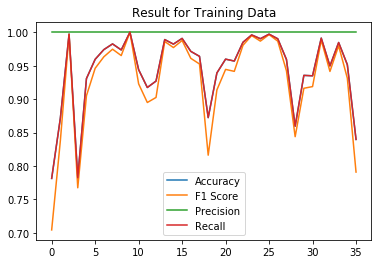

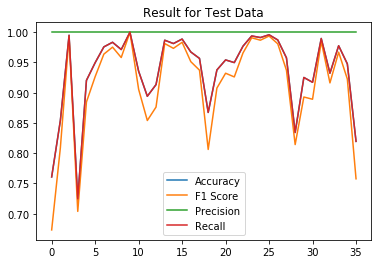

Training Data Mean Results:
Accuracy     0.945311
F1 Score     0.929410
Precision    1.000000
Recall       0.945311
dtype: float64
Test Data Mean Results:
Accuracy     0.936536
F1 Score     0.914519
Precision    1.000000
Recall       0.936536
dtype: float64


In [14]:
# Predict using the best tuned model (from GridSearchCV)
# These predictions are made on both the training and test data
y_pred_train = best_model_rf_tuned.predict(X_train)
y_pred_test = best_model_rf_tuned.predict(X_test)

# Initialize a list to store metrics for the training data
train_results = []

# Loop through each target label (column) in the training data
for i, column in enumerate(Y_train.columns):
    # Call the 'get_metrics' function to compute accuracy, precision, recall, and F1 for each column
    result = get_metrics(Y_train.loc[:, column].values, y_pred_train[:, i])
    train_results.append(result)  # Store the metrics in the 'train_results' list

# Convert the list of results to a DataFrame for better visualization
train_results_df = pd.DataFrame(train_results)

# Display the DataFrame for training results
train_results_df

# Initialize a list to store metrics for the test data
test_results = []

# Loop through each target label (column) in the test data
for i, column in enumerate(Y_test.columns):
    # Call the 'get_metrics' function to compute accuracy, precision, recall, and F1 for each column
    result = get_metrics(Y_test.loc[:, column].values, y_pred_test[:, i])
    test_results.append(result)  # Store the metrics in the 'test_results' list

# Convert the list of results to a DataFrame for better visualization
test_results_df = pd.DataFrame(test_results)

# Display the DataFrame for test results
test_results_df

# Plot the performance metrics for the training data
train_results_df.plot()
plt.title("Result for Training Data")
plt.show()

# Plot the performance metrics for the test data
test_results_df.plot()
plt.title("Result for Test Data")
plt.show()

# Calculate and print the mean of the performance metrics for the training data
# This will give an overall view of how well the model performed on training data
print("Training Data Mean Results:")
print(train_results_df.mean())

# Calculate and print the mean of the performance metrics for the test data
# This will give an overall view of how well the model performed on test data
print("Test Data Mean Results:")
print(test_results_df.mean())

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [23]:
print(Y_train.nunique())  # For training labels
print(Y_test.nunique())   # For testing labels

# Check unique classes in each column for training labels
for column in Y_train.columns:
    print(f"Training labels for '{column}':")
    print(Y_train[column].value_counts())
    print("\n")  # Add a newline for better readability

# Check unique classes in each column for testing labels
for column in Y_test.columns:
    print(f"Testing labels for '{column}':")
    print(Y_test[column].value_counts())
    print("\n")  # Add a newline for better readability

related                   3
request                   2
offer                     2
aid_related               2
medical_help              2
medical_products          2
search_and_rescue         2
security                  2
military                  2
child_alone               1
water                     2
food                      2
shelter                   2
clothing                  2
money                     2
missing_people            2
refugees                  2
death                     2
other_aid                 2
infrastructure_related    2
transport                 2
buildings                 2
electricity               2
tools                     2
hospitals                 2
shops                     2
aid_centers               2
other_infrastructure      2
weather_related           2
floods                    2
storm                     2
fire                      2
earthquake                2
cold                      2
other_weather             2
direct_report       

In [28]:
# Custom transformer to extract the length of the message
class MessageLengthExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X.str.len())


# Create a pipeline with feature union
pipeline_improved = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
        ('text_length', MessageLengthExtractor())
    ])),
    ('clf', MultiOutputClassifier(AdaBoostClassifier()))
])


# Train the improved pipeline
pipeline_improved.fit(X_train, Y_train)

# Predict on the test data
y_pred_test_improved = pipeline_improved.predict(X_test)

# Evaluate the improved model
test_results_improved = []
for i, column in enumerate(Y_test.columns):
    result = get_metrics(Y_test.iloc[:, i].values, y_pred_test_improved[:, i])
    test_results_improved.append(result)

test_results_improved_df = pd.DataFrame(test_results_improved)
print("Test Results with AdaBoost and Message Length:")
print(test_results_improved_df.mean())

Test Results with AdaBoost and Message Length:
Accuracy     0.946870
F1 Score     0.939634
Precision    1.000000
Recall       0.946870
dtype: float64


### 9. Export your model as a pickle file

In [29]:
import pickle  # Import pickle for saving models

# After fitting the model and obtaining the best estimator
best_model_rf_tuned = cv_rf_tuned.best_estimator_

# Print out the best parameters and the best accuracy score
print("Best Parameters:", best_params)
print("Best Accuracy Score from GridSearchCV:", best_score)

# Save the model to a pickle file
filename = 'classifier.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model_rf_tuned, file)

# Confirm the model has been saved
print(f"Best model saved as '{filename}'")

# AdaBoost model trained
filename_adaboost = 'adaboost_classifier.pkl'
with open(filename_adaboost, 'wb') as file:
    pickle.dump(pipeline_improved, file)

print(f"AdaBoost model saved as '{filename_adaboost}'")

Best Parameters: {'clf__estimator__criterion': 'entropy', 'clf__estimator__max_depth': 40, 'clf__estimator__max_features': 'auto', 'clf__estimator__random_state': 42}
Best Accuracy Score from GridSearchCV: 0.935808591349
Best model saved as 'classifier.pkl'
AdaBoost model saved as 'adaboost_classifier.pkl'


### 10. Use this notebook to complete `train_classifier.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.